# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [73]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [74]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'south'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [75]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [76]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: south
step 1 - action: west
step 2 - action: east
step 3 - action: north
step 4 - action: east
step 5 - action: south
step 6 - action: west
step 7 - action: west
step 8 - action: south
step 9 - action: east
step 10 - action: west
step 11 - action: suck
step 12 - action: suck
step 13 - action: east
step 14 - action: south
step 15 - action: east
step 16 - action: west
step 17 - action: west
step 18 - action: north
step 19 - action: suck


3

# Tasks

## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [77]:
def environment(agent, max_steps, n, verbose=False):
  # create random number generator
  rng = np.random.default_rng()

  # initialize n by n environment with clean/dirty squares with 0.2 probability of any square being dirty
  env = rng.choice([0, 1], size=(n,n), p=[0.8, 0.2])

  # sum the ndarray to find the number of dirty squares
  num_dirty = env.sum()

  # generate a random starting position for the robot
  pos = rng.integers(low=0, high=n, size=2)

  # loop until max_steps is reached
  for i in range(max_steps):

    # return number of steps used if room is clean
    if num_dirty == 0:
      return i

    # determine percepts and provide agent with them, resulting in an action
    bumpers = {"north": pos[0] == 0, "south": pos[0] == n - 1, "west": pos[1] == 0, "east": pos[1] == n - 1}
    dirty = env[pos[0], pos[1]]
    action = agent(bumpers, dirty)

    # verbose output
    if verbose:
      print(env, pos)
      print("step", i , "- action:", action)
      print()

    # environment reacting to action of agent
    if action == "suck":
      # if on dirty square, clean it
      if env[pos[0], pos[1]] == 1:
        env[pos[0], pos[1]] = 0
        num_dirty -= 1
    elif action == "north" and not bumpers["north"]:
      pos[0] -= 1
    elif action == "south" and not bumpers["south"]:
      pos[0] += 1
    elif action == "west" and not bumpers["west"]:
      pos[1] -= 1
    elif action == "east" and not bumpers["east"]:
      pos[1] += 1

  # return max_steps if robot fails to clean room
  return max_steps

# environment(simple_randomized_agent, 100000, 100, verbose=False)

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [78]:
def simple_reflex_agent(bumpers, dirty):
  # if dirty, then suck
  if dirty:
    return "suck"
  # else, move in a random direction where the bumper is false
  else:
    return np.random.choice([k for k, v in bumpers.items() if not v])

# environment(simple_reflex_agent, 100000, 100, verbose=False)

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [79]:
# The agent state will be its previous and current position.
# A 1D array of length 2 will be used to store each.
# Whenever the agent leaves a square, that square must be clean and does not need to be returned to.
# The agent moves, from the northwest corner, south until it reaches a wall, east once, north until it reaches a wall, east once, and repeats.

In [80]:
# class to store state
class model_based_reflex_agent:

  # intitialize agent
  def __init__(self):
    self.prev = None
    self.pos = None

  # agent returns an action based on percepts
  def act(self, bumpers, dirty):
    # if agent has not reached NW corner, move north and west there
    if not self.pos:
      if not bumpers["north"]:
        return "north"
      if not bumpers["west"]:
        return "west"
      # at this point, the north and west bumpers are true, so set current position to [0, 0]
      self.pos = [0, 0]

    # if dirty, then suck
    if dirty:
      return "suck"
    # else, attempt to go north, then attempt to go south, and if both are not possible, go east
    # when the agent is facing the south or north wall, it can not go backwards to its previous position
    # and can not bump into the wall, so it goes east
    else:
      # checks if it can go north and that it is not going backwards
      if not bumpers["north"] and self.prev != [self.pos[0] - 1, self.pos[1]]:
        # update previous and current position
        self.prev = [self.pos[0], self.pos[1]]
        self.pos[0] -= 1
        return "north"
      # checks if it can go south and that it is not going backwards
      elif not bumpers["south"] and self.prev != [self.pos[0] + 1, self.pos[1]]:
        # update previous and current position
        self.prev = [self.pos[0], self.pos[1]]
        self.pos[0] += 1
        return "south"
      # else, go east
      else:
        # update previous and current position
        self.prev = [self.pos[0], self.pos[1]]
        self.pos[1] += 1
        return "east"

# environment(model_based_reflex_agent().act, 100000, 100, verbose=False)

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each with 100000 max steps. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [81]:
def simulate(agent, inst=False):
  # steps for 5x5, 10x10, 100x100 environments
  five = ten = hundred = 0

  # simulate 100 times
  for i in range(100):
    # if agent is a class and needs to be instantiated
    if inst:
      # add steps for each simulation
      five += environment(agent().act, 100000, 5)
      ten += environment(agent().act, 100000, 10)
      hundred += environment(agent().act, 100000, 100)
    # else, use the agent directly
    else:
      # add steps for each simulation
      five += environment(agent, 100000, 5)
      ten += environment(agent, 100000, 10)
      hundred += environment(agent, 100000, 100)

  # find average by dividing by 100
  five /= 100
  ten /= 100
  hundred /= 100

  #return array of average steps for 5x5, 10x10, 100x100 environments
  return [five, ten, hundred]

# simple_randomized = simulate(simple_randomized_agent)
# simple_reflex = simulate(simple_reflex_agent)
# model_based_reflex = simulate(model_based_reflex_agent, inst=True)

# print("simple randomized agent:", simple_randomized)
# print("simple reflex agent:", simple_reflex)
# print("model-based reflex agent:", model_based_reflex)

In [82]:
# Output of code above (in arrays of 5x5, 10x10, 100x100):

# simple randomized agent: [438.76, 3020.05, 100000.0]
# simple reflex agent: [112.41, 902.91, 100000.0]
# model-based reflex agent: [28.54, 125.33, 12089.62]

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |438.76 |112.41 |28.54 |
| 10x10   |3020.05 |902.91 |125.33 |
| 100x100 |100000.0 |100000.0 |12089.62 |


Add charts to compare the performance of the different agents.

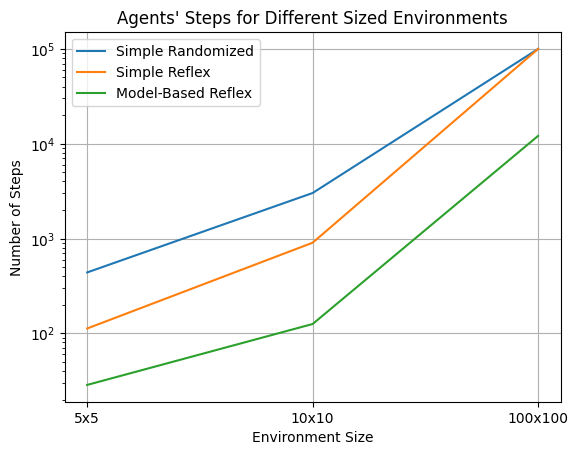

In [83]:
# Run the below code to see the graph. The y-axis is log scaled.
# The simple randomized agent used 3 to 4 times more steps than the simple reflex agent in the 5x5 and 10x10 environments.
# In the 100x100 environment, both the simple randomized agent and the simple reflex agent were unable to fully clean all the dirt and used the maximum number of steps.
# The number of steps the model-based reflex agent used is several times lower than the other two agents for all environments,
# which makes sense as the other two agents include some level of randomness in their actions while the model-based reflex agent does not.

import matplotlib.pyplot as plt

agents = ["Simple Randomized", "Simple Reflex", "Model-Based Reflex"]
env_sizes = ["5x5", "10x10", "100x100"]
simple_randomized = [438.76, 3020.05, 100000.0]
simple_reflex = [112.41, 902.91, 100000.0]
model_based_reflex = [28.54, 125.33, 12089.62]

plt.plot(env_sizes, simple_randomized)
plt.plot(env_sizes, simple_reflex)
plt.plot(env_sizes, model_based_reflex)
plt.title("Agents' Steps for Different Sized Environments")
plt.legend(agents)
plt.xlabel("Environment Size")
plt.ylabel("Number of Steps")
plt.yscale("log")
plt.grid("on")

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

In [84]:
# Simple Randomized Agent:
# Will succeed if there is no limit on steps in each of the three scenarios and will not have its performance affected by the scenarios, because it is completely random

# Simple Reflex Agent:
# Will succeed if there is no limit on steps in each of the three scenarios and will not have its performance affected by the scenarios, because it moves randomly

# Model-Based Reflex Agent:
# Will succeed in a rectangular room of unknown size, because it will move north and west until both its north and west bumper sensors sense a wall
# At that point, it will systematically clean the room with the algorithmn I implemented, which works in any rectangular room
# Will fail if the cleaning area is irregularly shaped, because the algorithmn I implemented only works in a rectangular room
# Will fail if the room contains obstacles, because the algorithm I implemented only works in a rectangular room with no obstacles
# *The algorithm is explained in the model-based reflex agent section



---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
